<img src="https://www.mykoweb.com/CAF/photos/large/Agaricus_augustus%28mgw-02%29.jpg" width="700">

## Introduction

This notebook is about a classification of mushrooms into edible and poisonous categories. The data set was taken form the UCI repository, the origin of its records is The Audubon Society Field Guide to North American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred A. Knopf, and it was donated by Jeff Schlimmer.

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be" for Poisonous Oak and Ivy. (from UCI)

The goal of this notebook is partly to refute the very Guide's statement above by showing how almost all of the classification models get a perfect score. We will see how the reason for the perfect score yields a very simple rule of how to easily classify mushrooms without any need of statistical tools. As a consequence, the primary idea of this notebook is to do some features reduction in order to seek for interesting variations that would allow us to construct and analyze models with imperfect but yet good scores. This notebook describes with comments a step-by-step process of selecting 3 variations of models.

### Attribute information (from the UCI page):

1. cap-shape: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
2. cap-surface: fibrous=f, grooves=g, scaly=y, smooth=s
3. cap-color: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
4. bruises?: bruises=t, no=f
5. odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
6. gill-attachment: attached=a, descending=d, free=f, notched=n
7. gill-spacing: close=c, crowded=w, distant=d
8. gill-size: broad=b, narrow=n
9. gill-color: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
10. stalk-shape: enlarging=e, tapering=t
11. stalk-root: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
12. stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s
13. stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s
14. stalk-color-above-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
15. stalk-color-below-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
16. veil-type: partial=p, universal=u
17. veil-color: brown=n, orange=o, white=w, yellow=y
18. ring-number: none=n, one=o, two=t
19. ring-type: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
20. spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
21. population: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
22. habitat: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from urllib import request
import os

from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, chi2, mutual_info_classif

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, classification_report, roc_curve, auc

from lime import lime_tabular
import random

## Loading data set

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
data = request.urlopen(url)
dfcolumns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type", "spore-print-color", "population", "habitat"]
df = pd.read_csv(data, sep=",", skiprows=0, names=dfcolumns)
# df.to_csv(os.getcwd() + "\\Mushrooms.csv", index=False)

In [5]:
df['ring-type'].unique()

array(['p', 'e', 'l', 'f', 'n'], dtype=object)

## Exploratory analysis

In [3]:
df.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [4]:
df.shape

(8124, 23)

In [5]:
# Lets see the unique values in the datafrmame
print("Unique values:")
for col in df.columns:
    print(col + ":", df[col].unique())

Unique values:
class: ['p' 'e']
cap-shape: ['x' 'b' 's' 'f' 'k' 'c']
cap-surface: ['s' 'y' 'f' 'g']
cap-color: ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises: ['t' 'f']
odor: ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment: ['f' 'a']
gill-spacing: ['c' 'w']
gill-size: ['n' 'b']
gill-color: ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape: ['e' 't']
stalk-root: ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring: ['s' 'f' 'k' 'y']
stalk-surface-below-ring: ['s' 'f' 'y' 'k']
stalk-color-above-ring: ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring: ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type: ['p']
veil-color: ['w' 'n' 'o' 'y']
ring-number: ['o' 't' 'n']
ring-type: ['p' 'e' 'l' 'f' 'n']
spore-print-color: ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population: ['s' 'n' 'a' 'v' 'y' 'c']
habitat: ['u' 'g' 'm' 'd' 'p' 'w' 'l']


#### Missing values (compared to the UCI attribute information):

- gill-attachment: d, n.
- gill-spacing: d.
- stalk-root: u, z.
- veil-type: u.
- ring-type: c, s, z.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [7]:
# Checking for missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [8]:
df.describe()

class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top                         w                      w         p          w   
freq                     4464                   4384      8124       7924   

       ring-number ring-type spore-print-color population habitat  
count         8124      8124              8124       8124    8124  
unique           3         5                 9          6       7  
top              o         p                 w          v       d  
freq          7488      3968              2388       4040    3148  

[4 rows x 23 columns]

In [9]:
# Checking for duplicate samples
df[df.duplicated()].shape[0]

0

In [10]:
# Count-plots all of the features in the dataframe
def features_countplot(df):
    fig, axs = plt.subplots(8, 3, figsize=(14,30), constrained_layout=True)
    for i, f in enumerate(df.columns):
        sb.countplot(x=f, data=df, ax=axs[i//3][i%3])
    plt.show()

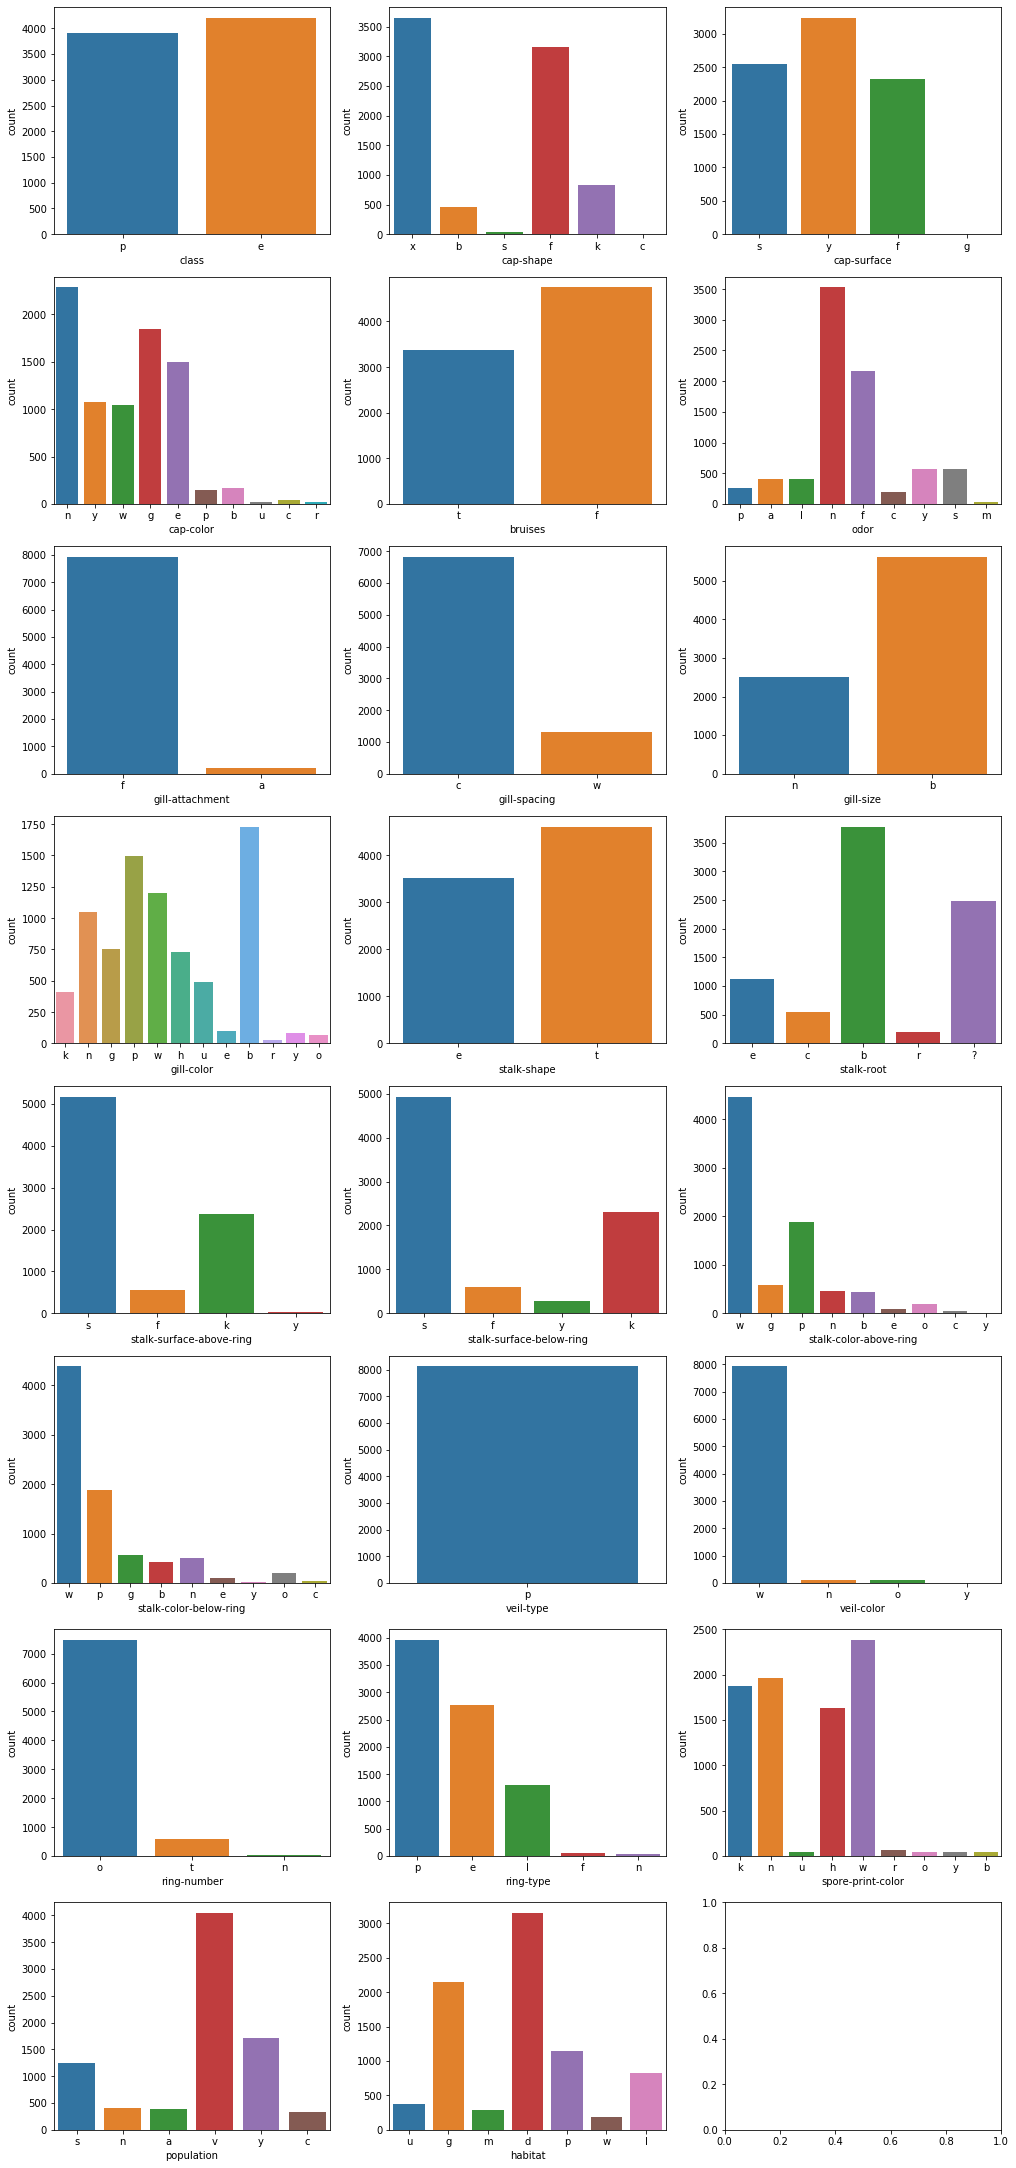

In [11]:
features_countplot(df)

The class distribution is balanced; and since all of the features are categoric there's no need to scale the data.

#### Inspecting rare values:

In [12]:
# Prints a frequency of values under a threshold
def values_freq(df, n):
    print("Number of values with frequency of less than", str(n) + ":")
    for col in df.columns:
        for val in list(df[col].unique()):
            if df[col][df[col] == val].count() < n:
                print(col, "of type", val + ":", df[col][df[col] == val].count())

In [13]:
values_freq(df, 10)

Number of values with frequency of less than 10:
cap-shape of type c: 4
cap-surface of type g: 4
stalk-color-above-ring of type y: 8
veil-color of type y: 8


# Preprocessing

In [14]:
# As we've noticed above, there's only 1 veil-type so we can drop the whole feature out
df.drop("veil-type", axis=1, inplace=True)

### Data encoding:

In [15]:
# Gets a OneHotEncoder matrix and returns it as a dataframe with the dummy columns of df
def ohe_to_df(ohe, df):
    columns = pd.get_dummies(df, drop_first=True).columns
    ohe_df = pd.DataFrame(ohe, columns=columns[1:]).astype("int")
    ohe_df.insert(0, "class", df["class"])
    ohe_df["class"].replace({"e":1, "p":0}, inplace=True)
    return ohe_df

In [16]:
df2_encoder = OneHotEncoder(sparse=False, drop="first").fit(df.drop("class", axis=1))
df2 = ohe_to_df(df2_encoder.transform(df.drop("class", axis=1)), df)

In [17]:
df2.head()

class  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  cap-shape_x  \
0      0            0            0            0            0            1   
1      1            0            0            0            0            1   
2      1            0            0            0            0            0   
3      0            0            0            0            0            1   
4      1            0            0            0            0            1   

   cap-surface_g  cap-surface_s  cap-surface_y  cap-color_c  ...  \
0              0              1              0            0  ...   
1              0              1              0            0  ...   
2              0              1              0            0  ...   
3              0              0              1            0  ...   
4              0              1              0            0  ...   

   population_n  population_s  population_v  population_y  habitat_g  \
0             0             1             0             0          0   
1             1             0             0             0          1   
2             1             0             0             0          0   
3             0             1             0             0          0   
4             0             0             0             0          1   

   habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  
0          0          0          0          1          0  
1          0          0          0          0          0  
2          0          1          0          0          0  
3          0          0          0          1          0  
4          0          0          0          0          0  

[5 rows x 96 columns]

## Analysis

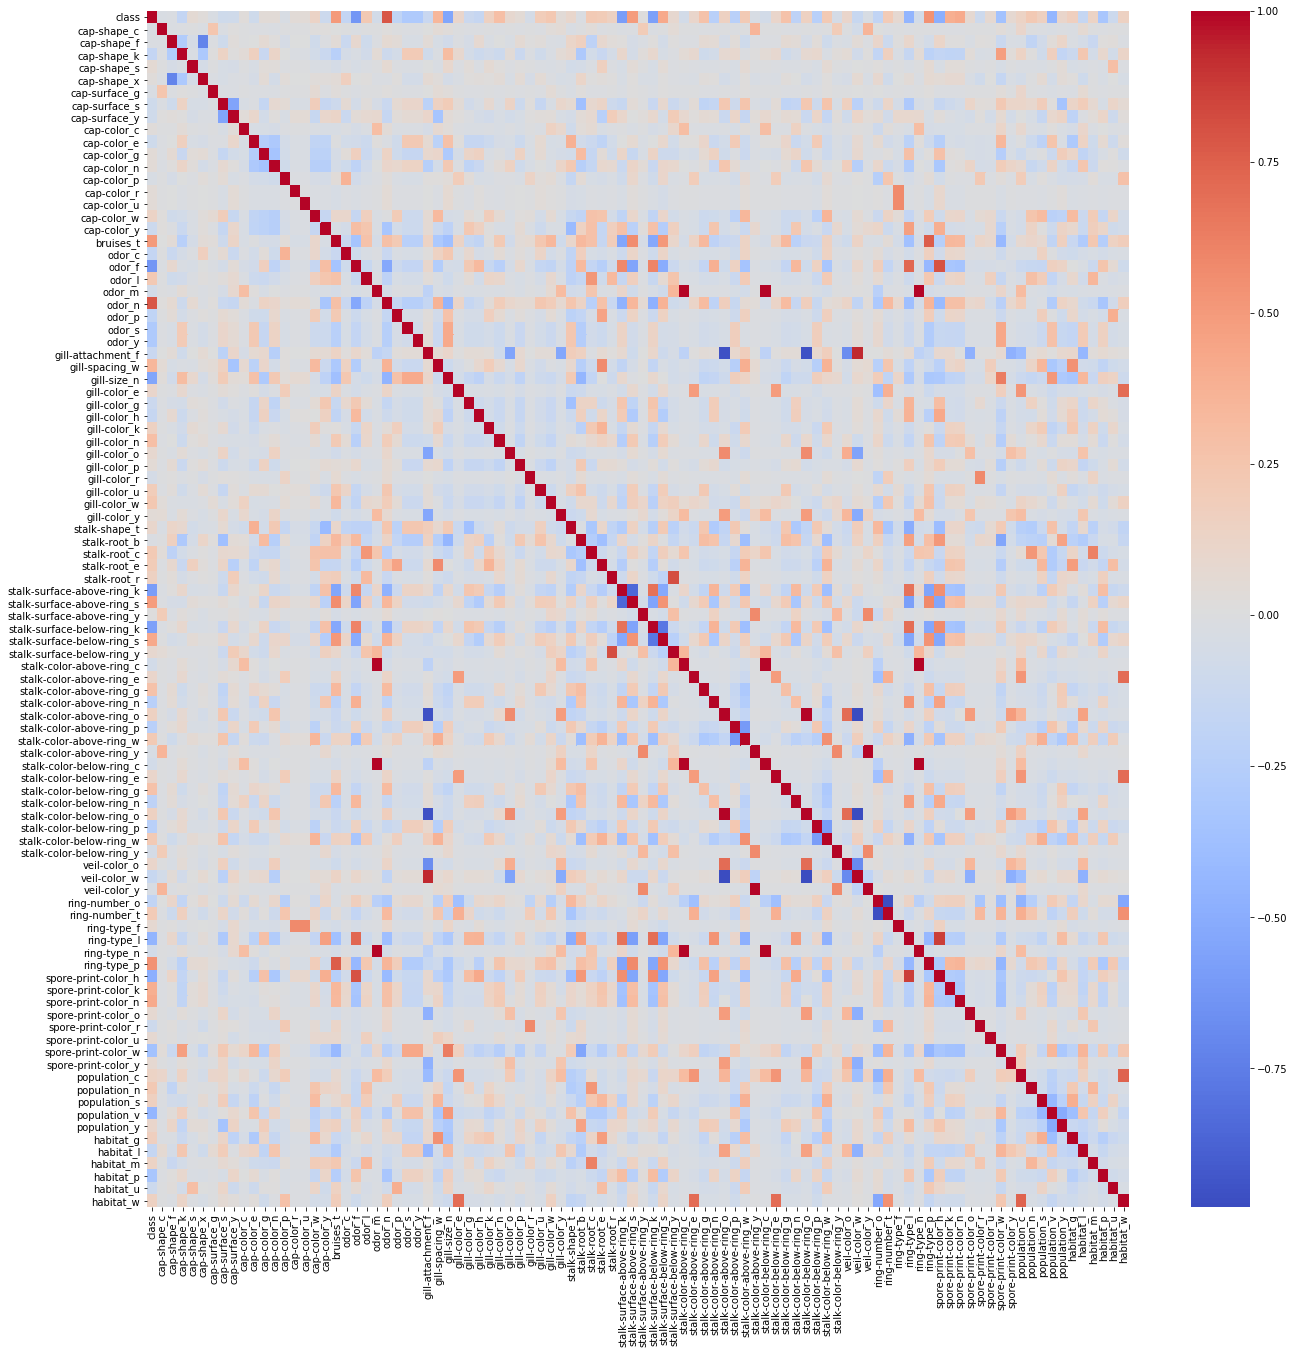

In [18]:
plt.figure(figsize=(22,22))
sb.heatmap(df2.corr(), cmap='coolwarm')

#### Pairs of highly correlated features:

In [19]:
# Prints pairs of features with a correlation that is greater than or equal to the given coefficient (in absolute value)
def df_corr_coeff(df, coeff):
    table = []
    upper = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(np.bool))
    for col in df.corr().columns:
        for i, val in enumerate(list(upper[col].dropna().values)):
            if abs(val) >= coeff:
                table.append((upper[col].dropna().name, df.corr().columns[i], val))
    table = pd.DataFrame(table, columns=["Feature 1", "Feature 2", "Correlation"])
    return table

In [20]:
df_corr_coeff(df2, 0.9)

Feature 1                 Feature 2  Correlation
0   stalk-color-above-ring_c                    odor_m     1.000000
1   stalk-color-above-ring_o         gill-attachment_f    -0.955097
2   stalk-color-below-ring_c                    odor_m     1.000000
3   stalk-color-below-ring_c  stalk-color-above-ring_c     1.000000
4   stalk-color-below-ring_o         gill-attachment_f    -0.955097
5   stalk-color-below-ring_o  stalk-color-above-ring_o     1.000000
6               veil-color_w         gill-attachment_f     0.935238
7               veil-color_w  stalk-color-above-ring_o    -0.979302
8               veil-color_w  stalk-color-below-ring_o    -0.979302
9               veil-color_y  stalk-color-above-ring_y     1.000000
10             ring-number_t             ring-number_o    -0.968959
11               ring-type_n                    odor_m     1.000000
12               ring-type_n  stalk-color-above-ring_c     1.000000
13               ring-type_n  stalk-color-below-ring_c     1.000000

In [21]:
# Deletes a feature for every pair of perfectly correlated features (disregarding the target feature)
def del_perfect_corr(df):
    
    features = df_corr_coeff(df, 1)
    if features.shape[0] == 0:
        return df
    features_groups = [{features["Feature 1"][0], features["Feature 2"][0]}]
    for i in range(1, features.shape[0]):
        if features["Feature 1"][i] not in set.union(*features_groups) and features["Feature 2"][i] not in set.union(*features_groups):
            features_groups.append({features["Feature 1"][i], features["Feature 2"][i]})
        elif features["Feature 1"][i] in set.union(*features_groups) and features["Feature 2"][i] in set.union(*features_groups):
            continue
        else:
            for group in features_groups:
                if features["Feature 1"][i] in group or features["Feature 2"][i] in group:
                    group.add(features["Feature 1"][i])
                    group.add(features["Feature 2"][i])
                    break
    for group in features_groups:
        group.pop()
        df = df.drop(group, axis=1)        
    return df

In [22]:
# In every group of perfectly correlated features we want to drop from the dataframe all features but one
df2 = del_perfect_corr(df2)

## Take 0: Initial evaluation

### Train-test split

In [23]:
X = df2.drop("class", axis=1)
y = df2["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Creating models

In [24]:
# Runs classification models using GridSearchCV or RandomizedSearhCV and outputs their best estimators
# and a table with their best scores and parameters
def run_models(X, y, searchCV):
    
    grid_params = {"Logistic Regression": {"model": LogisticRegression(), "params": {"C": [.1, 1, 8, 9, 10], "max_iter": [300], "solver": ["lbfgs", "liblinear"]}},
                     "SGD": {"model": SGDClassifier(), "params": {"loss": ["modified_huber"]}},
                     "KNN": {"model": KNeighborsClassifier(), "params": {"n_neighbors": range(1,10), "weights": ["uniform", "distance"]}},
                     "SVM": {"model": SVC(), "params": {"C": [.01, .1, .5, 1, 5, 10], "kernel": ["linear", "poly", "rbf", "sigmoid"]}},
                     "Naive Bayes": {"model": GaussianNB(), "params": {}},
                     "Decision Tree": {"model": DecisionTreeClassifier(), "params": {"criterion": ["gini", "entropy"]}},
                     "Random Forest": {"model": RandomForestClassifier(), "params": {"n_estimators": [50, 100, 200], "criterion": ["gini", "entropy"]}}}
    scores = []
    estimators = {}
    for model, mp in grid_params.items():
        clf = searchCV(mp["model"], mp["params"], scoring=make_scorer(fbeta_score, beta=.5), n_jobs=-1, cv=5)
        clf.fit(X, y)
        scores.append({"Model": model, "Best Score": clf.best_score_, "Best Parameters": clf.best_params_})
        estimators[model] = clf.best_estimator_
    print(pd.DataFrame(scores, columns=["Model", "Best Score", "Best Parameters"]).to_string())
    return estimators

We take the f_beta function with beta = 0.5 as the scoring function to lend more weight to precision because in this dataset it's important to keep the FP low (poisonous mushrooms that were falsely predicted to be edible).

In [25]:
estimators = run_models(X_train, y_train, GridSearchCV)

                 Model  Best Score                               Best Parameters
0  Logistic Regression    1.000000  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    1.000000                    {'loss': 'modified_huber'}
2                  KNN    1.000000      {'n_neighbors': 1, 'weights': 'uniform'}
3                  SVM    1.000000                {'C': 0.5, 'kernel': 'linear'}
4          Naive Bayes    0.922942                                            {}
5        Decision Tree    1.000000                         {'criterion': 'gini'}
6        Random Forest    1.000000     {'criterion': 'gini', 'n_estimators': 50}


In [26]:
# Gets a dictionary of estimators and returns a corresponding dictionary of predictions over a test set
def pred_dict(estimators, X_test):
    return dict(zip(estimators.keys(), [x.predict(X_test) for x in estimators.values()]))

In [27]:
predictions = pred_dict(estimators, X_test)

### Confusion matrices and Classification reports

In [28]:
# Plots confusion matrices for a dictionary of estimators
def confusion_mat(y_test, predictions):
    plt.figure(figsize=(18,12))
    plt.suptitle("Confusion Matrices",fontsize=30)
    plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
    
    for i, model in enumerate(predictions.keys()):
        plt.subplot(3,3,i + 1)
        plt.title(model, fontsize=15, pad=10)
        sb.heatmap(confusion_matrix(y_test, predictions[model]), annot=True, cmap="Blues", fmt="d",cbar=False, annot_kws={"size": 25})
    plt.show()

In [29]:
# Prints classification reports for a dictionary of estimators
def classification_rep(y_test, predictions):
    print("Classification Reports".center(125, "="))
    for i, model in enumerate(predictions.keys()):
        print(model.center(55, " "))
        print(classification_report(y_test, predictions[model]))
        print("*" * 54)

We have no need to use these functions for now because we got a perfect score, so we should further analyse the data to see what causes it.

# Feature Selection and Distribution

Let's see how the features from the original dataframe are distributed in the target.

In [30]:
# Plots the distribution of the features in the target
def feature_target_dist(df):
    fig, axs = plt.subplots(7, 3, figsize=(14,30), constrained_layout=True)
    for i, f in enumerate(df.drop("class", axis=1).columns):
        sb.countplot(x=f, hue="class", data=df, ax=axs[i//3][i%3])
    plt.show()

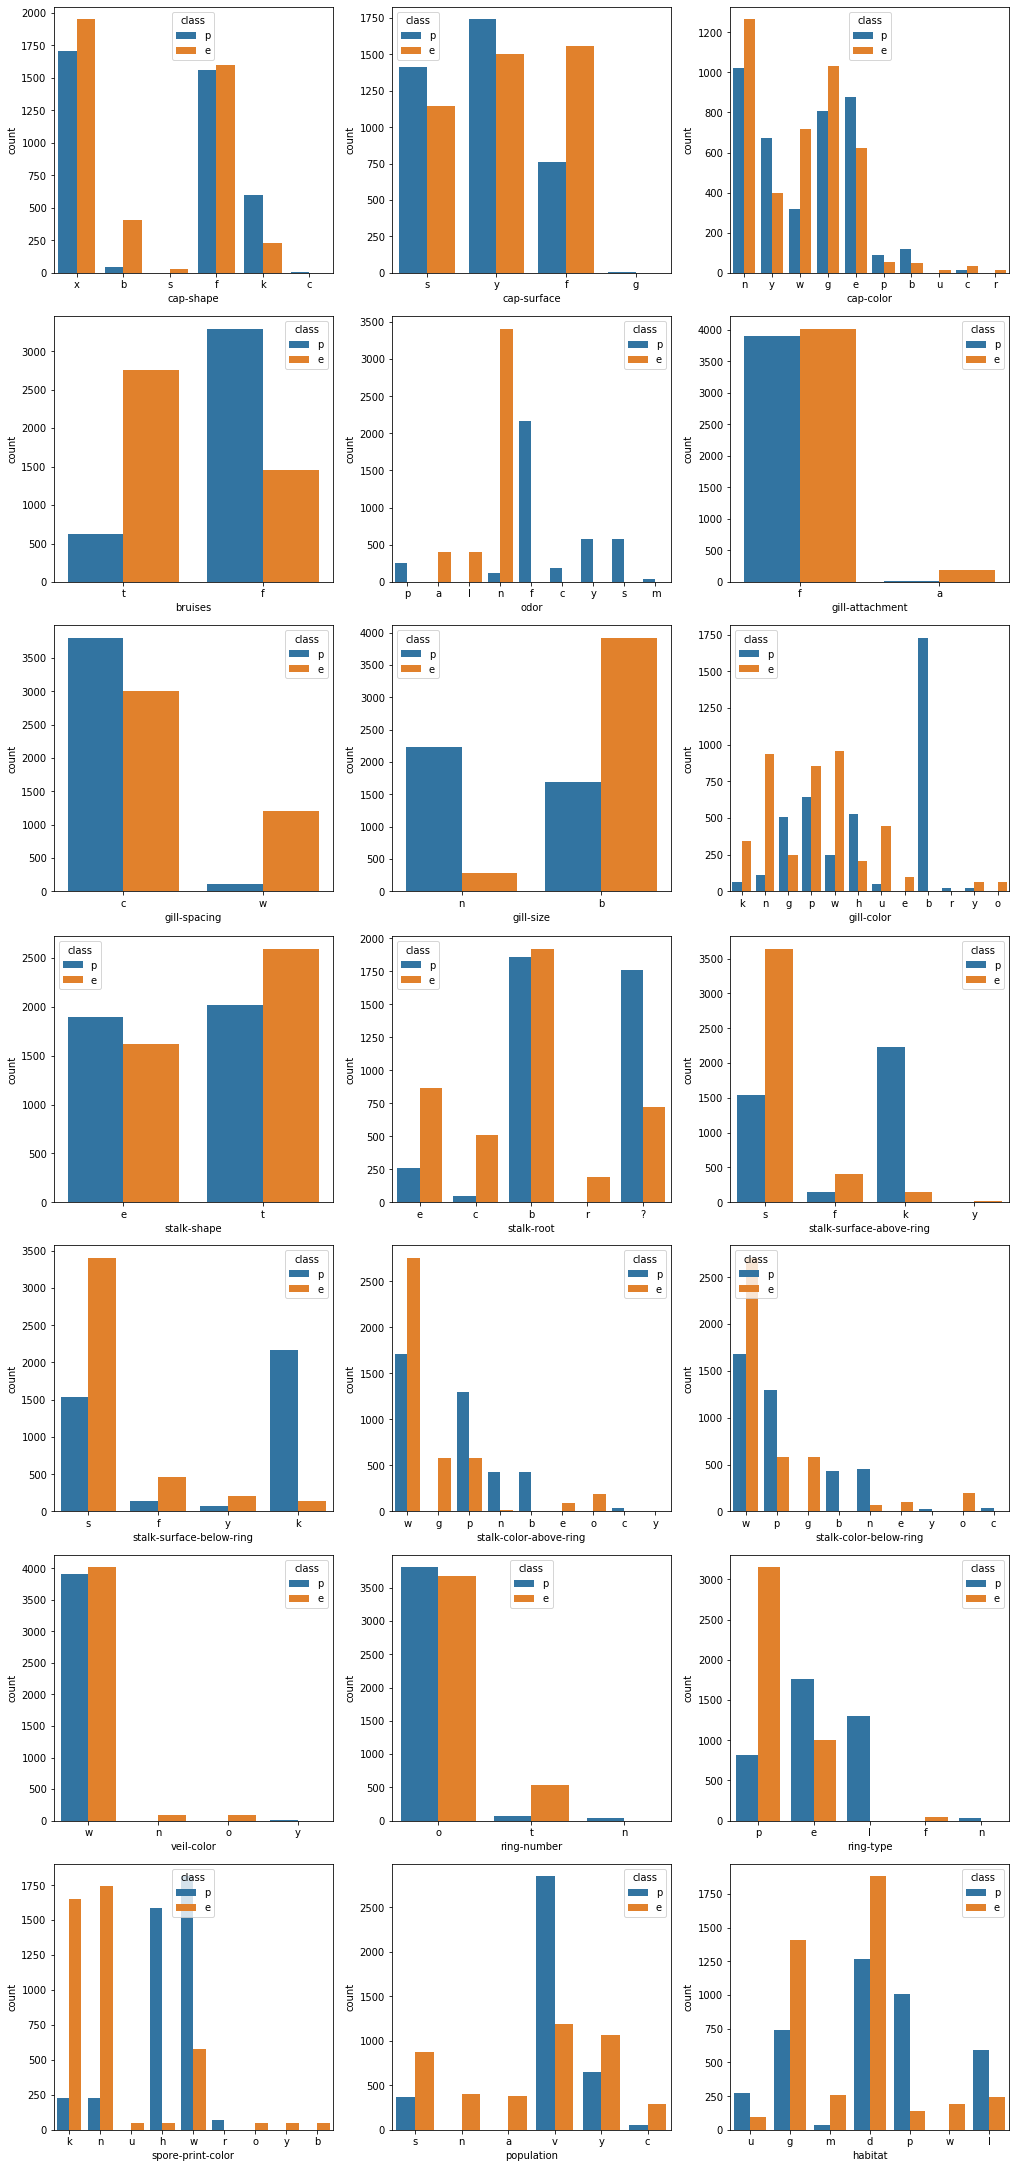

In [31]:
feature_target_dist(df)

We can see several features that are distributed in the target unequally, maybe the most prominent is odor.

In [32]:
# Prints the frequency of a given feature of a dataframe when it's grouped by the target
def feature_freq(df, feature):
    df = pd.get_dummies(df[["class", feature]], columns=[feature])
    for f in df.drop("class", axis=1).columns:
        fd = pd.DataFrame(df[["class", f]][df[f] == 1].groupby("class").count())
        fd["percent"] = fd[f] / fd[f].sum() * 100
        print(fd)
        print("*************************")

In [33]:
feature_freq(df, "odor")

       odor_a  percent
class                 
e         400    100.0
*************************
       odor_c  percent
class                 
p         192    100.0
*************************
       odor_f  percent
class                 
p        2160    100.0
*************************
       odor_l  percent
class                 
e         400    100.0
*************************
       odor_m  percent
class                 
p          36    100.0
*************************
       odor_n    percent
class                   
e        3408  96.598639
p         120   3.401361
*************************
       odor_p  percent
class                 
p         256    100.0
*************************
       odor_s  percent
class                 
p         576    100.0
*************************
       odor_y  percent
class                 
p         576    100.0
*************************


We see that all of the mushrooms with almond or anise odor are edible; all of the mushrooms with creosote, fishy, foul, musty, pungent and spicy odors are poisonous; and among the mushrooms without an odor almost 97% are edible. So the distribution of the  "odor" feature is strongly compatible with the distribution of the target, and apparently it's one of the causes that our models have perfect score. This observation actually draws a simple rule to determine the edibility of a mushroom, as opposed to the aforementioned Guide's statement. Let's run some features importance tests to see it more clearly.

In [34]:
# Plots statistical tests between the feature matrix X and the target vector y for n features with the highest scores
def stat_scores(X, y, n):
    
    fc = f_classif(X, y)
    chi = chi2(X, y)
    mi = mutual_info_classif(X, y, random_state=10)
    rfi = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10).fit(X, y).feature_importances_
    eti = ExtraTreesClassifier(n_estimators=100, random_state=10).fit(X, y).feature_importances_
    
    plt.title("ANOVA F-value stats")
    plot_feature_rank(X, fc[0], n)
    
    plt.title("Chi-squared stats")
    plot_feature_rank(X, chi[0], n)
    
    plt.title("Mutual Information stats")
    plot_feature_rank(X, mi, n)
    
    plt.title("Random Forest Importance")
    plot_feature_rank(X, rfi, n)
    
    plt.title("Extra Trees Importance")
    plot_feature_rank(X, eti, n)

In [35]:
# Plots a chart of n important features from X using stat test
def plot_feature_rank(X, stat, n):
    pd.Series(stat).sort_values(ascending=False).nlargest(n).plot.bar(figsize = (16,4))
    plt.xticks(range(0,n), X.columns[pd.Series(stat).sort_values(ascending=False).nlargest(n).index], rotation=20)
    plt.show()

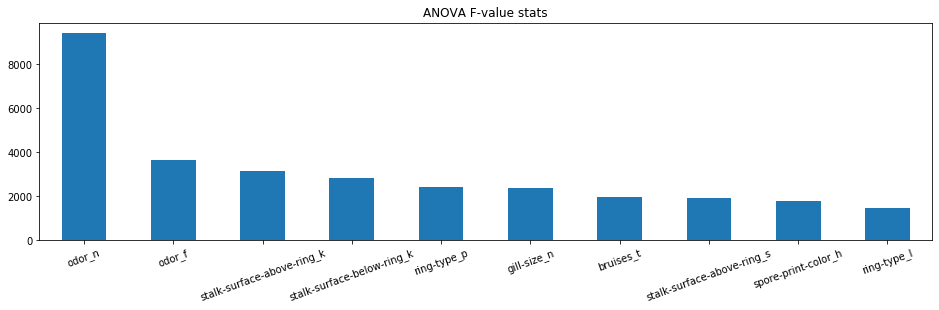

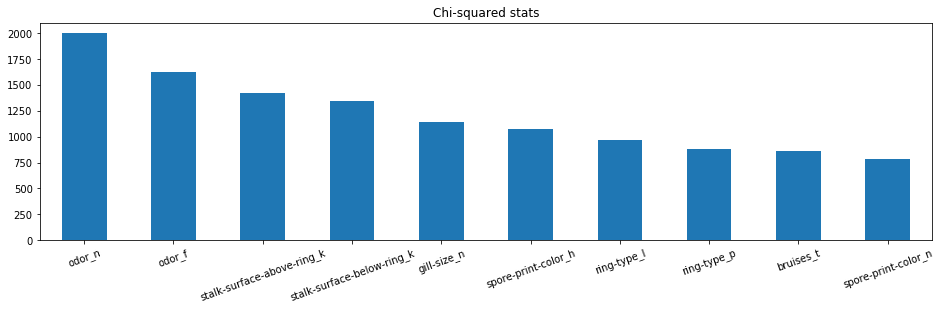

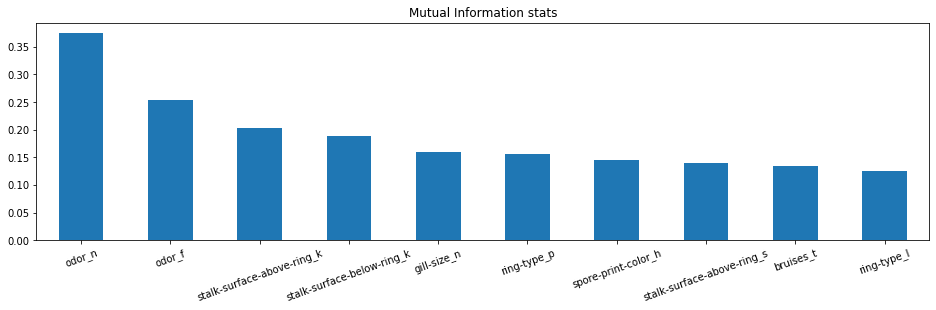

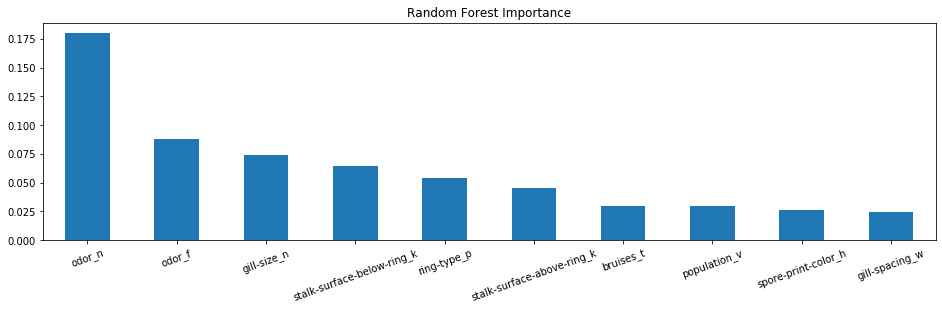

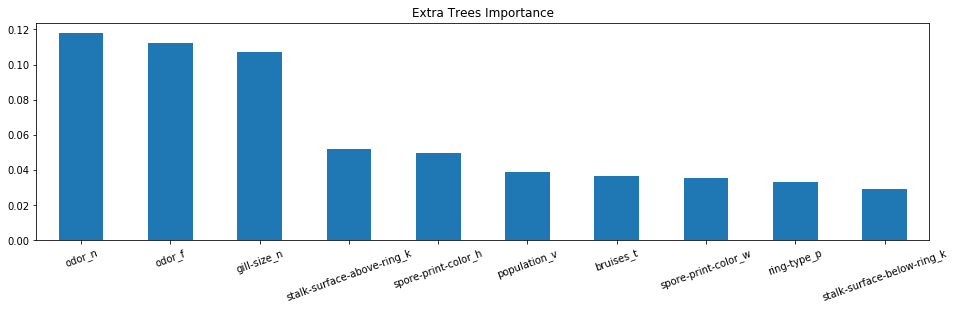

In [36]:
stat_scores(X_train, y_train, 10)

We can see the 'none odor' has significant dominance compared to the rest of the values, and hence the next step would be to drop the whole feature out and see where it leads us. Before that we just add a small section of LIME interpretability that we will use later on.

### Interpretability:

In [37]:
# Explaining the model with LIME by locally choosing a random test sample (DOES NOT WORK FOR SVM)
def lime_exp(X_train, X_test, model, n=10):
    explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)
    exp = explainer.explain_instance(X_test.iloc[random.randint(0, len(X_test) - 1)], model.predict_proba, num_features=n)
    exp.show_in_notebook()

In [38]:
lime_exp(X_train, X_test, estimators["KNN"])

## Take 1 (anosmic): Data without the odor feature

In [39]:
original_df3 = df.drop("odor", axis=1)

df3_encoder = OneHotEncoder(sparse=False, drop="first").fit(original_df3.drop("class", axis=1))
df3 = ohe_to_df(df3_encoder.transform(original_df3.drop("class", axis=1)), original_df3)

df3 = del_perfect_corr(df3)

X2 = df3.drop("class", axis=1)
y2 = df3["class"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=10)

estimators2 = run_models(X_train2, y_train2, GridSearchCV)

                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.999117  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.998978                    {'loss': 'modified_huber'}
2                  KNN    1.000000      {'n_neighbors': 3, 'weights': 'uniform'}
3                  SVM    1.000000                  {'C': 0.5, 'kernel': 'poly'}
4          Naive Bayes    0.845629                                            {}
5        Decision Tree    1.000000                      {'criterion': 'entropy'}
6        Random Forest    1.000000     {'criterion': 'gini', 'n_estimators': 50}


We still get a perfect score in most of the models, and that's probably because of other features with high importance. Now, instead of shaving a few more features with high importance or low variance off of the dataframe, we should make it interesting and establish thinner variations of the data set, from which we shall focus on those that don't yield a prefect score but yet a decent one.

## Take 2 (anti-anosmic): Data with only the odor feature

In [40]:
original_df4 = df[["class", "odor"]]

df4_encoder = OneHotEncoder(sparse=False, drop="first").fit(original_df4.drop("class", axis=1))
df4 = ohe_to_df(df4_encoder.transform(original_df4.drop("class", axis=1)), original_df4)

df4 = del_perfect_corr(df4)

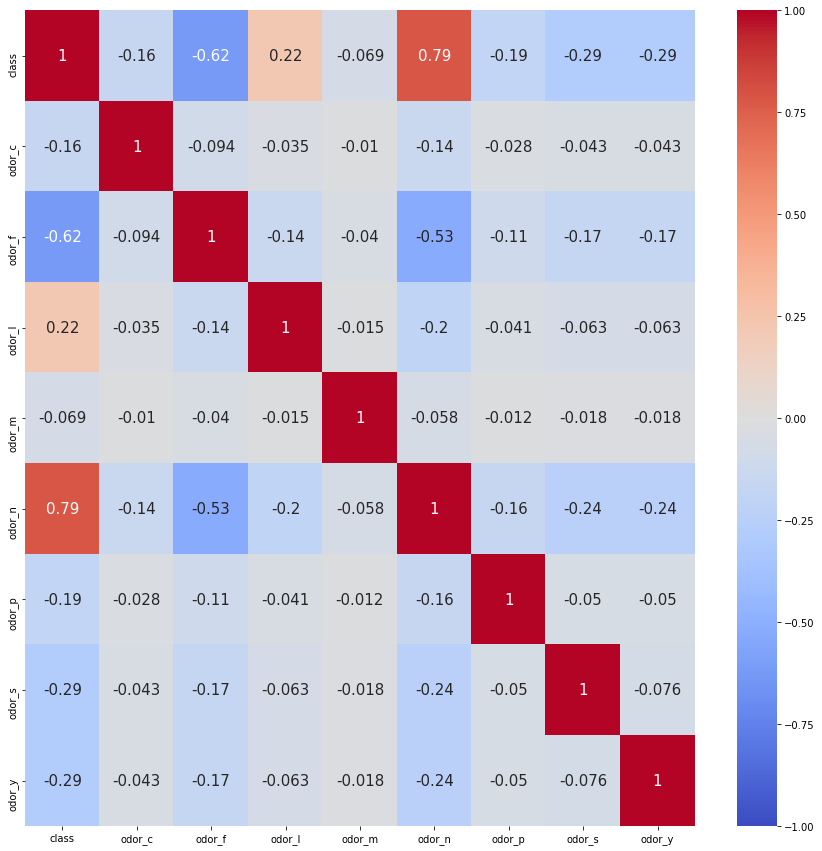

In [41]:
plt.figure(figsize=(15,15))
sb.heatmap(df4.corr(), cmap='coolwarm', annot=True, vmin=-1, annot_kws={"fontsize":15})

In [42]:
X3 = df4.drop("class", axis=1)
y3 = df4["class"]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=10)

estimators3 = run_models(X_train3, y_train3, GridSearchCV)

                 Model  Best Score                                 Best Parameters
0  Logistic Regression    0.977079  {'C': 0.1, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.977079                      {'loss': 'modified_huber'}
2                  KNN    0.977079        {'n_neighbors': 1, 'weights': 'uniform'}
3                  SVM    0.977079                   {'C': 0.01, 'kernel': 'poly'}
4          Naive Bayes    0.977079                                              {}
5        Decision Tree    0.977079                           {'criterion': 'gini'}
6        Random Forest    0.977079       {'criterion': 'gini', 'n_estimators': 50}


Considering what we've seen above it's not very surprising that we get almost a perfect score (that is also identical across all of the models), and therefore we have no use for this variation.

## Take 3: Colors only

In [43]:
original_df5 = df[["class"] + [i for i in df.columns if "color" in i]]

df5_encoder = OneHotEncoder(sparse=False, drop="first").fit(original_df5.drop("class", axis=1))
df5 = ohe_to_df(df5_encoder.transform(original_df5.drop("class", axis=1)), original_df5)

df5 = del_perfect_corr(df5)

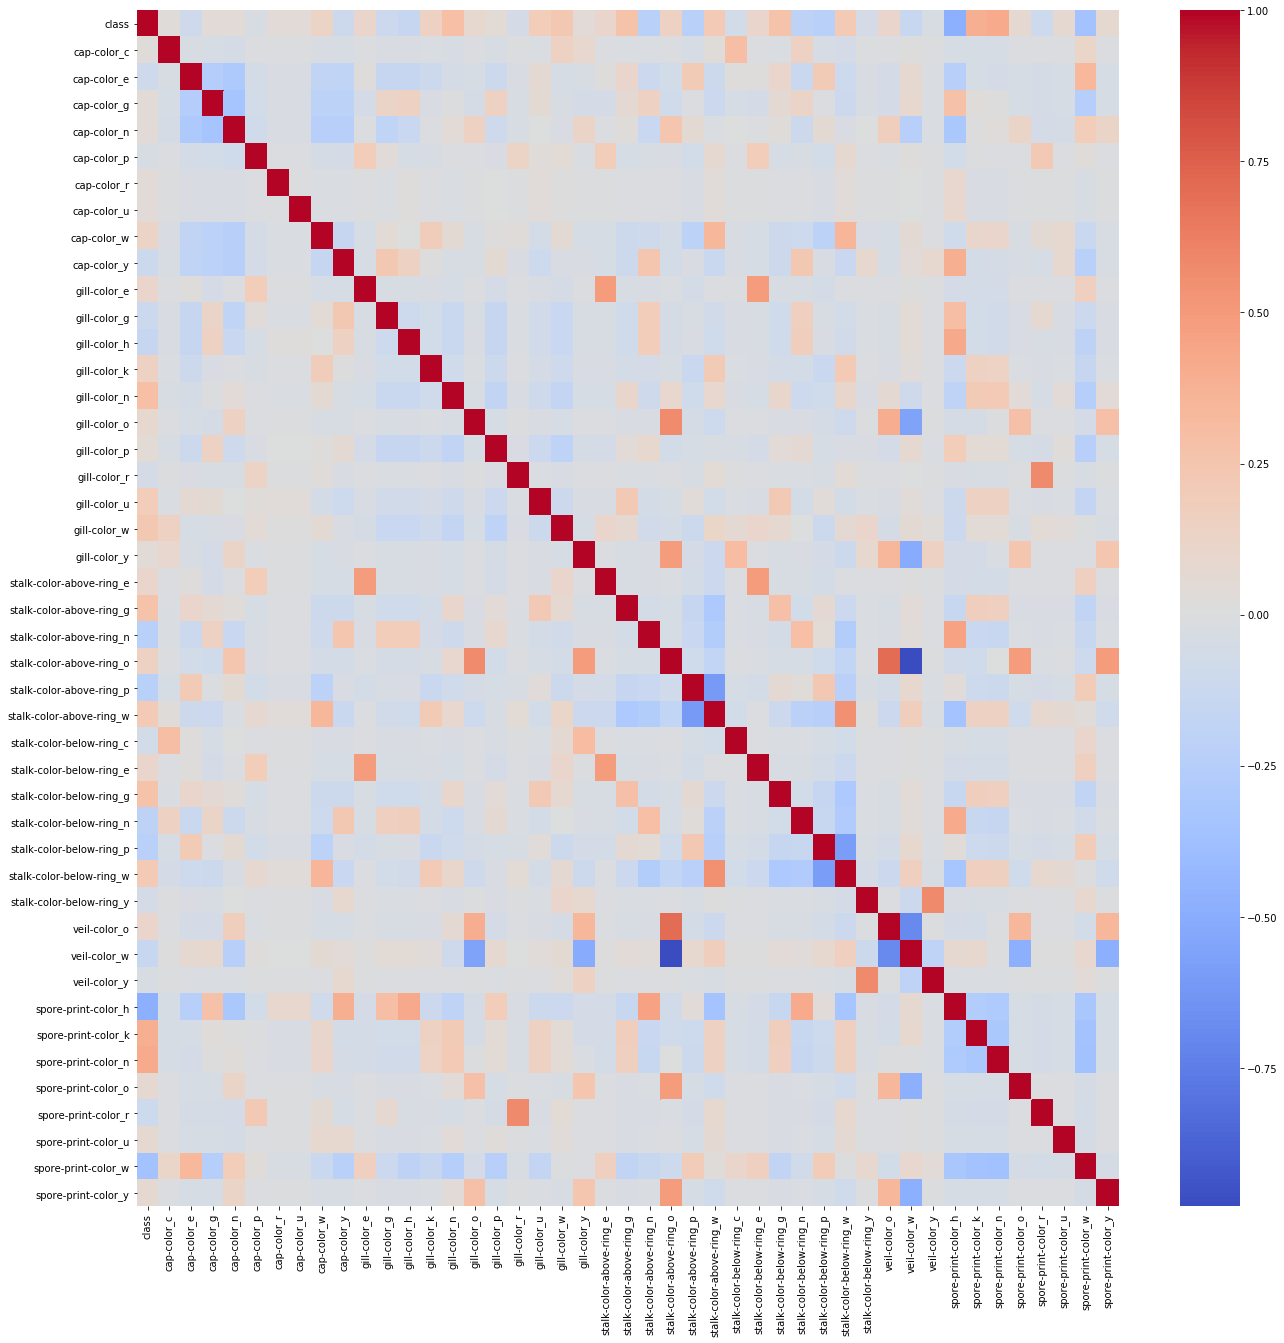

In [44]:
plt.figure(figsize=(22,22))
sb.heatmap(df5.corr(), cmap='coolwarm')

In [45]:
X4 = df5.drop("class", axis=1)
y4 = df5["class"]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=10)

estimators4 = run_models(X_train4, y_train4, GridSearchCV)

                 Model  Best Score                                Best Parameters
0  Logistic Regression    0.928814  {'C': 10, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.928652                     {'loss': 'modified_huber'}
2                  KNN    0.936460      {'n_neighbors': 9, 'weights': 'distance'}
3                  SVM    0.934299                     {'C': 5, 'kernel': 'poly'}
4          Naive Bayes    0.725494                                             {}
5        Decision Tree    0.934289                          {'criterion': 'gini'}
6        Random Forest    0.934450     {'criterion': 'gini', 'n_estimators': 100}


Well, that's an interesting variation. The KNN model got the highest score, so as for now that's the model to go with.

### Attempts to improve the models:

We will use several ways to try improving the models.

In [46]:
# Runs a variance threshold algorithm and returns the features with a variance that is lower than the threshold
def var_threshold(X, threshold):
    vt = VarianceThreshold(threshold)
    vt.fit(X)
    low_var_features = [x for x in X.columns if x not in X.columns[vt.get_support()]]
    print("Feaures with variance of less than " + str(threshold) + ":", ", ".join(low_var_features))
    print("Number of remaining features:", sum(vt.get_support()))
    return low_var_features

In [47]:
# Runs the KNN model and plots a chart of K values from 1 to n with their scores
def best_knn(X, y, n):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    scoreList = []
    for i in range(1,n + 1):
        knn = GridSearchCV(KNeighborsClassifier(n_neighbors = i, n_jobs=-1), {"weights": ["uniform", "distance"]}, scoring=make_scorer(fbeta_score, beta=.5), cv=5)
        knn.fit(X_train, y_train)
        scoreList.append(knn.best_score_)
    plt.plot(range(1,n + 1), scoreList)
    plt.xticks(np.arange(1,n + 1,1))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.show()
    print("Maximum KNN Score:", max(scoreList), "for K =", scoreList.index(max(scoreList)) + 1)

In [48]:
# Fixes the multicolinearity of a dataframe by dropping features with high Variance Inflation Factor (VIF) until all features
# have a VIF of less than n. Returns the updated dataframe and the VIF dataframe with VIF values of the remaining features
def fix_multicolinearity(df, n):
    
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    while any(i > n for i in vif["VIF"].values):
        for f in range(1, df.shape[1]):
            if vif.iloc[f][1] > n:
                df = df.drop(vif.iloc[f][0], axis=1)
                break
        vif = pd.DataFrame()
        vif["features"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return df, vif

In [49]:
X4_1 = X4.drop(var_threshold(X4, 0.005), axis=1)
X_train4_1, X_test4_1, y_train4_1, y_test4_1 = train_test_split(X4_1, y4, test_size=0.3, random_state=10)
estimators4_1 = run_models(X_train4_1, y_train4_1, GridSearchCV)

Feaures with variance of less than 0.005: cap-color_r, cap-color_u, gill-color_r, stalk-color-below-ring_c, stalk-color-below-ring_y, veil-color_y
Number of remaining features: 38
                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.926279  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.923225                    {'loss': 'modified_huber'}
2                  KNN    0.935229     {'n_neighbors': 9, 'weights': 'distance'}
3                  SVM    0.932989                    {'C': 5, 'kernel': 'poly'}
4          Naive Bayes    0.712589                                            {}
5        Decision Tree    0.932977                         {'criterion': 'gini'}
6        Random Forest    0.933145    {'criterion': 'gini', 'n_estimators': 100}


We can see that by removing some features with low variance still none of the models is better than our previous KNN, and therefore removing low variance features is not a good idea here (tested with a variety of thresholds).

In [50]:
X4_2 = SelectPercentile(chi2, percentile=90).fit_transform(X4, y4)
X_train4_2, X_test4_2, y_train4_2, y_test4_2 = train_test_split(X4_2, y4, test_size=0.3, random_state=10)
estimators4_2 = run_models(X_train4_2, y_train4_2, GridSearchCV)

                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.918871  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.918069                    {'loss': 'modified_huber'}
2                  KNN    0.931007     {'n_neighbors': 2, 'weights': 'distance'}
3                  SVM    0.926160                     {'C': 5, 'kernel': 'rbf'}
4          Naive Bayes    0.722686                                            {}
5        Decision Tree    0.926383                         {'criterion': 'gini'}
6        Random Forest    0.926316  {'criterion': 'entropy', 'n_estimators': 50}


Selecting 90% of the best features doesn't improve our models either (tested with a variety of functions and percentiles).

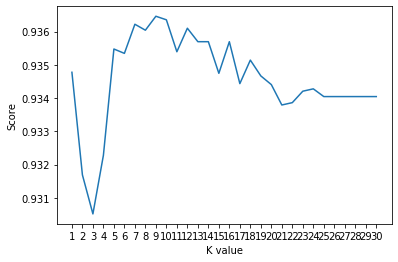

Maximum KNN Score: 0.936460431181261 for K = 9


In [51]:
best_knn(X4, y4, 30)

Increasing the n neighbors for the KNN doesn't improve it.

In [52]:
new_df5, df5_vif = fix_multicolinearity(df5, 10)
X4_3 = new_df5.drop("class", axis=1)
y4_3 = new_df5["class"]
X_train4_3, X_test4_3, y_train4_3, y_test4_3 = train_test_split(X4_3, y4_3, test_size=0.3, random_state=10)

estimators4_3 = run_models(X_train4_3, y_train4_3, GridSearchCV)

                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.921169  {'C': 9, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.916757                    {'loss': 'modified_huber'}
2                  KNN    0.936624     {'n_neighbors': 9, 'weights': 'distance'}
3                  SVM    0.934066                    {'C': 5, 'kernel': 'poly'}
4          Naive Bayes    0.725494                                            {}
5        Decision Tree    0.934289                         {'criterion': 'gini'}
6        Random Forest    0.934527     {'criterion': 'gini', 'n_estimators': 50}


Fixing the multicolinearity using VIF does improve the KNN by a bit.

In [53]:
predictions4 = pred_dict(estimators4, X_test4)

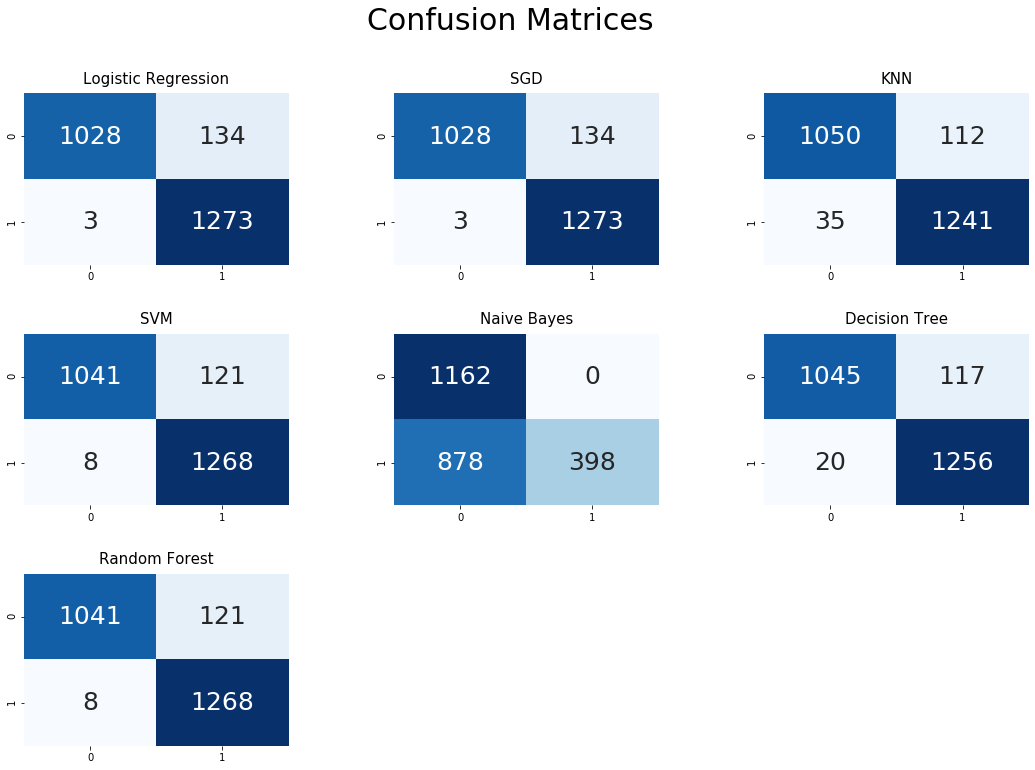

In [54]:
confusion_mat(y_test4, predictions4)

We get an interesting observation from the confusion matrices. FP in these models means that a poisonous mushroom was predicted to be edible, so ideally we would want to minimize the FP as much as possible. KNN got the best score overall but its FP is not the lowest. Naive Bayes got the worst score with a huge amount of FN but it has no FP at all, so it's basically the safest model!

In [55]:
predictions4_3 = pred_dict(estimators4_3, X_test4_3)

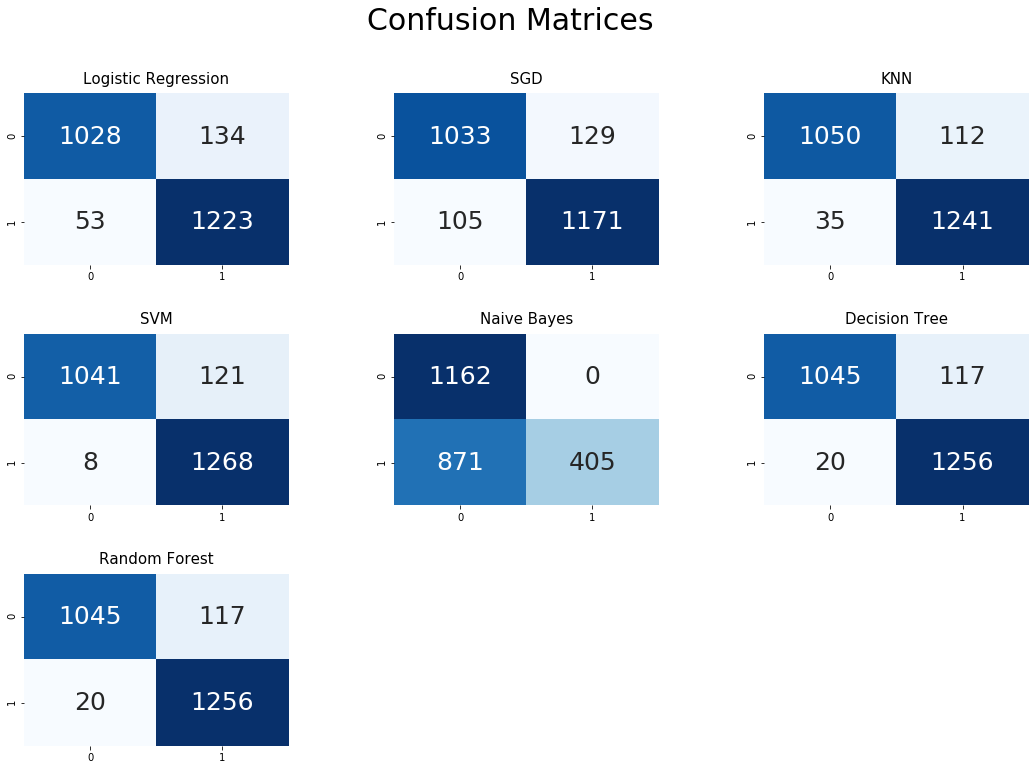

In [56]:
confusion_mat(y_test4_3, predictions4_3)

The confusion matrices of both the fixed multicolinearity KNN and the original KNN are the same, so we'll continue with the previous KNN for now.

# Postprocessing

### Threshold optimization:

In this section we would want to take our current estimators and optimize their decision thresholds in order to decrease the FP rate. We would do that in 3 steps: 
- Creating predict-proba sets by splitting them over the train set using KFold (to avoid over-fitting).
- Using these sets to calculate f_0.5 scores on all of the possible thresholds of the corresponding untrained estimators (with the same parameters).
- For each estimator, taking the threshold that yields the highest score.

In [57]:
# Trains a model using KFold cross-validation on X and y and returns a dataframe with the labels and concatinated
# predict_probas for each split. The idea is to use it to find an optimal threshold without an overfitting risk on the test set
def kfold_predict_proba(X, y, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    clf = model
    pp_df = pd.DataFrame(columns=["Label", "Predict_proba"])
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        clf.fit(X_train, y_train)
        pp_df = pd.concat([pp_df, pd.DataFrame({"Label": y_test, "Predict_proba": clf.predict_proba(X_test)[:,1]})], axis=0)
    return pp_df

In [58]:
# Plots ROC curves of estimators using K-fold predcit_proba
def roc_curves(X, y, estimators):
    
    estimators2 = dict(estimators)
    estimators2.pop("SVM")
    fig, axs = plt.subplots(2, 3, figsize=(15,9), constrained_layout=True)
    for i, clf in enumerate(estimators2.values()):
        clf_pp = kfold_predict_proba(X, y, clf)
        label = clf_pp["Label"].tolist()
        pp = clf_pp["Predict_proba"].tolist()
        fpr, tpr, thresholds = roc_curve(label, pp)
        area = auc(fpr, tpr)
        axs[i//3][i%3].plot(fpr, tpr, linestyle="-", label='ROC curve (area = %0.2f)' % area)
        axs[i//3][i%3].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=list(estimators2.keys())[i])
        axs[i//3][i%3].legend()
    fig.suptitle("ROC Curves", fontsize=20)
    plt.show()

In [59]:
# Gets a dictionary of trained estimators and returns a dictionary of the same estimators but untrained and with the same 
# parameters
def untrain_models(estimators):
    new_clfs = []
    for clf in estimators.values():
        new_clfs.append(eval(type(clf).__name__)().set_params(**clf.get_params()))
    return dict(zip(estimators.keys(), new_clfs))

In [60]:
# roc_curves(X_train4, y_train4, estimators4)

In [61]:
# Given lists of predict_proba and labels, returns the best threshold under f_0.5 scoring
def best_threshold(pred_df):
    label = pred_df["Label"].tolist()
    pred_proba = pred_df["Predict_proba"].tolist()
    fpr, tpr, thresholds = roc_curve(label, pred_proba)
    scores = np.array([fbeta_score(label, pred_proba >= thr, beta=.5) for thr in thresholds])
    return thresholds[scores.argmax()]

In [62]:
# Gets a dictionary of optimal thresholds for given estimators and X, y train sets
def best_thresholds_dict(X, y, estimators):
    thresholds = []
    for clf in untrain_models(estimators).values():
        if type(clf).__name__ == "SVC":
            thresholds.append(0.5)
        else:
            thresholds.append(best_threshold(kfold_predict_proba(X, y, clf)))
    return dict(zip(estimators.keys(), thresholds))

In [63]:
# Model prediction by a given decision threshold
def predict_by_threshold(model, threshold, test):
    if type(model).__name__ == "SVC":
        return model.predict(test)
    return (model.predict_proba(test)[:,1] >= threshold).astype("int")

In [64]:
# Returns a dictionary of models predictions by the corresponding decision thresholds
def pred_by_threshold_dict(estimators, thresholds, test):
    preds = []
    for i, clf in enumerate(estimators.values()):
        preds.append(predict_by_threshold(clf, thresholds[list(thresholds.keys())[i]], test))
    return dict(zip(estimators.keys(), preds))

In [65]:
thresholds4 = best_thresholds_dict(X_train4, y_train4, estimators4)

In [66]:
predictions4 = pred_by_threshold_dict(estimators4, thresholds4, X_test4)

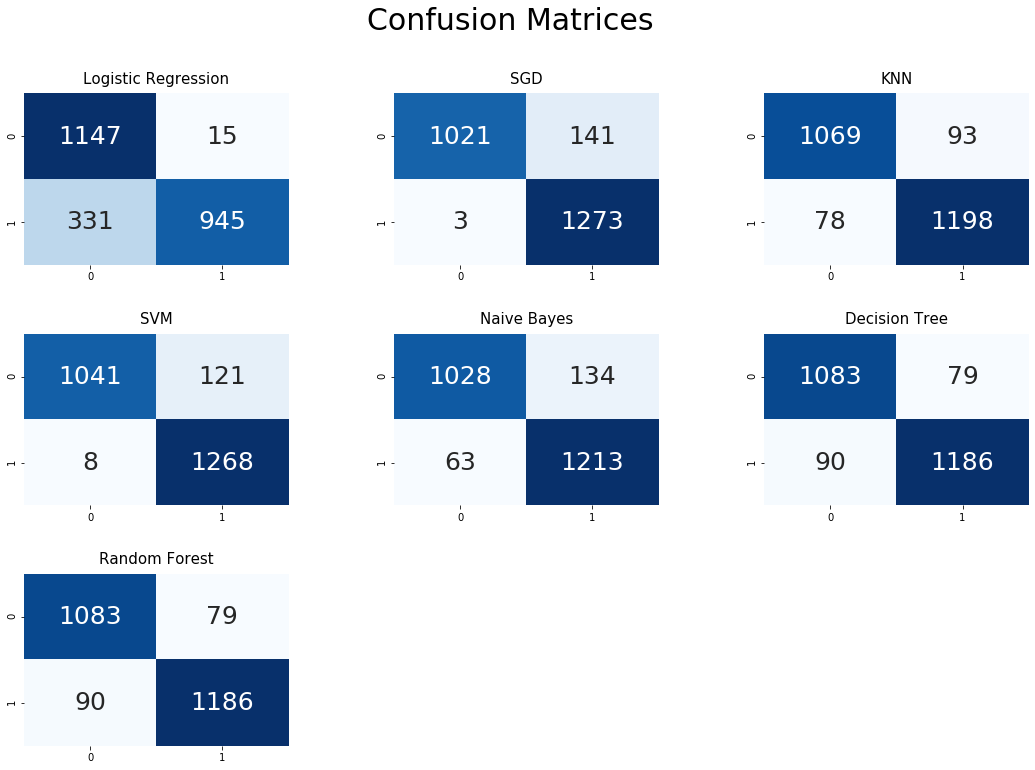

In [67]:
confusion_mat(y_test4, predictions4)

In [68]:
classification_rep(y_test4, predictions4)

====================================================Classification Reports===================================================
                  Logistic Regression                  
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1162
           1       0.98      0.74      0.85      1276

    accuracy                           0.86      2438
   macro avg       0.88      0.86      0.86      2438
weighted avg       0.89      0.86      0.86      2438

******************************************************
                          SGD                          
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      1162
           1       0.90      1.00      0.95      1276

    accuracy                           0.94      2438
   macro avg       0.95      0.94      0.94      2438
weighted avg       0.95      0.94      0.94      2438

*****************************************************

We optimized our thresholds by the f_0.5 scoring function to increase the precision in order to decrease the FP, and we got the following results on the test set:
- The FP of the Logistic Regression, SGD, KNN, Decision Tree and Random Forest were decreased.
- The FP of the Naive Bayes was increased (apparently because it previously had 100% precision and now we forced some FP).
- The confusion matrix of the SVM remained the same (because SVM is not a probabilistic algorithm and hence it has no decision threshold).

We can draw the following conclusions:
- If we were to seek for the safest model, the previous Naive Bayes has no FP at all, but on the other hand it does have 871 FN, which eventually granted it a very low score. A good candidate for a very safe model would be the current Logistic Regression which has only a few more FP than the previous Naive Bayes but more than 500 FN less.
- Even though the KNN got the highest score, the Decision Tree and Random Forest were previously very close to it with only a 0.002 difference. Now we can see their current "thresholded" versions have 12 more FN but 14 less FP, which to me grants them to be the final model to end up with.

In [69]:
colors_clf = estimators4["Random Forest"]
colors_threshold = thresholds4["Random Forest"]

In [70]:
# Returns the indices of the removed columns during the preprocessing stage
def removed_indices(original_df, df):
    cols = pd.get_dummies(original_df.drop("class", axis=1), drop_first=True).columns
    return [cols.tolist().index(x) for x in cols if x not in df.columns]

In [71]:
# Gets a dataframe and its deleted indices during the preprocessing and returns the updated unique values as a matrix
def unique_values2(df, del_idx):
    
    unique_mat = []
    del_col = pd.get_dummies(df.drop("class", axis=1), drop_first=True).columns[del_idx]
    for f in df.drop("class", axis=1).columns:
        values = df[f].unique().tolist()
        for c in del_col:
            if f == c[:-2]:
                values.remove(c[-1])
        unique_mat.append(values)
    return unique_mat

To wrap everything up, I made a class that takes the final model and uses it to make predictions.

In [72]:
# Class for the final model we achieved after all the analysis. Gets the estimator, its best decision threshold, the original 
# dataframe, the OHE fitted object of the original dataframe and the indices of the removed columns during the preprocessing
class MushroomModel:
    
    def __init__(self, estimator, threshold, df, encoder, del_idx):
        self.estimator = estimator
        self.threshold = threshold
        self.df = df
        self.encoder = encoder
        self.del_idx = del_idx
        self.uniques = unique_values2(df, del_idx)
        
    def random_predict(self):
        sample = []
        for i, col in enumerate(self.df.drop("class", axis=1).columns):
            sample.append(random.choice(self.uniques[i]))
            print(col + ":", sample[-1])
        return self.predict(sample)
        
    def sample_fit(self, sample):
        sample = self.encoder.transform(np.array(sample).reshape(1,-1))[0]
        sum_check = sample.sum()
        sample = np.array([x for i, x in enumerate(sample) if i not in self.del_idx]).reshape(1,-1)
        if sum_check != sample.sum():
            raise ValueError("Invalid input")
        return sample
    
    def predict(self, sample):
        sample = self.sample_fit(sample)
        est_name = type(self.estimator).__name__
        if  est_name == "SVC" or est_name == "KMeans":
            return self.estimator.predict(sample)
        return (self.estimator.predict_proba(sample)[:,1] >= self.threshold).astype("int")

In [73]:
colors_model = MushroomModel(colors_clf, colors_threshold, original_df5, df5_encoder, removed_indices(original_df5, df5))

In [74]:
sample = ['n','k','n','n','w','k']

In [75]:
colors_model.predict(sample)

array([1])

In [76]:
lime_exp(X_train4, pd.DataFrame(colors_model.sample_fit(sample)), colors_clf)

In [77]:
colors_model.random_predict()

cap-color: y
gill-color: p
stalk-color-above-ring: p
stalk-color-below-ring: w
veil-color: w
spore-print-color: w


array([0])

In [78]:
# lime_exp(X_train4, X_test4, colors_clf)

## Take 4: Area (population + habitat)

In [79]:
original_df6 = df[["class", "population", "habitat"]]

df6_encoder = OneHotEncoder(sparse=False, drop="first").fit(original_df6.drop("class", axis=1))
df6 = ohe_to_df(df6_encoder.transform(original_df6.drop("class", axis=1)), original_df6)

df6 = del_perfect_corr(df6)

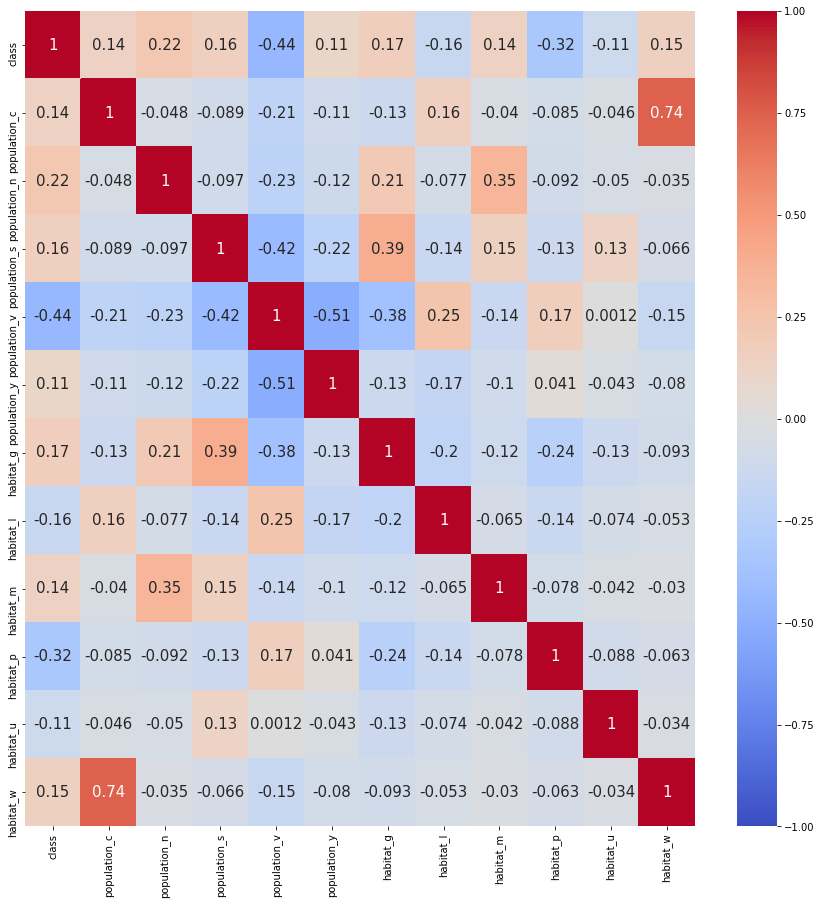

In [80]:
plt.figure(figsize=(15,15))
sb.heatmap(df6.corr(), cmap='coolwarm', annot=True, vmin=-1, annot_kws={"fontsize":15})

In [81]:
X5 = df6.drop("class", axis=1)
y5 = df6["class"]
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.3, random_state=10)

estimators5 = run_models(X_train5, y_train5, GridSearchCV)

                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.781609  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.768953                    {'loss': 'modified_huber'}
2                  KNN    0.785253      {'n_neighbors': 6, 'weights': 'uniform'}
3                  SVM    0.786714                   {'C': 0.1, 'kernel': 'rbf'}
4          Naive Bayes    0.523488                                            {}
5        Decision Tree    0.779613                         {'criterion': 'gini'}
6        Random Forest    0.779613     {'criterion': 'gini', 'n_estimators': 50}


Another interseting variation that is very thin in terms of features and yet yields not very bad scores. We shall go through the whole process like we did in the last variation, and meanwhile the candidate for the best model is the SVM.

### Attempts to improve the models:

In [82]:
X5_1 = X5.drop(var_threshold(X5, 0.05), axis=1)
X_train5_1, X_test5_1, y_train5_1, y_test5_1 = train_test_split(X5_1, y5, test_size=0.3, random_state=10)
estimators5_1 = run_models(X_train5_1, y_train5_1, GridSearchCV)

Feaures with variance of less than 0.05: population_c, population_n, habitat_m, habitat_u, habitat_w
Number of remaining features: 6
                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.763640  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.733607                    {'loss': 'modified_huber'}
2                  KNN    0.816550      {'n_neighbors': 8, 'weights': 'uniform'}
3                  SVM    0.816550                  {'C': 0.1, 'kernel': 'poly'}
4          Naive Bayes    0.688881                                            {}
5        Decision Tree    0.816550                         {'criterion': 'gini'}
6        Random Forest    0.816550     {'criterion': 'gini', 'n_estimators': 50}


We can see that removing the 5 features with a variance threshold of less than 0.05 decreases a bit the scores of the Logistic Regression and SGD but improves the KNN, SVM, Decision Tree and Random Forest models to the same score, so as for now each one of them is a candidate to be the model to go with (tested with a variety of thresholds and picked the one that yielded the best score). I think the fact we removed almost half of the features and yet received better models might imply the data set is not very balanced...

In [83]:
X5_2 = SelectPercentile(chi2, percentile=90).fit_transform(X5_1, y5)
X_train5_2, X_test5_2, y_train5_2, y_test5_2 = train_test_split(X5_2, y5, test_size=0.3, random_state=10)
estimators5_2 = run_models(X_train5_2, y_train5_2, GridSearchCV)

                 Model  Best Score                                 Best Parameters
0  Logistic Regression    0.751317  {'C': 0.1, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.724376                      {'loss': 'modified_huber'}
2                  KNN    0.777852        {'n_neighbors': 6, 'weights': 'uniform'}
3                  SVM    0.777852                    {'C': 0.1, 'kernel': 'poly'}
4          Naive Bayes    0.688881                                              {}
5        Decision Tree    0.777852                           {'criterion': 'gini'}
6        Random Forest    0.777852       {'criterion': 'gini', 'n_estimators': 50}


Selecting 90% of the best features doesn't improve our models (tested with a variety of functions and percentiles).

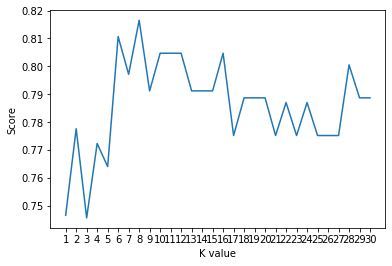

Maximum KNN Score: 0.8165496876006685 for K = 8


In [84]:
best_knn(X5_1, y5, 30)

Increasing the n neighbors for the KNN doesn't yield a better KNN.

In [85]:
new_df6, df6_vif = fix_multicolinearity(df6, 10)
X5_3 = new_df6.drop("class", axis=1).drop(var_threshold(X5, 0.05), axis=1)
y5_3 = new_df6["class"]
X_train5_3, X_test5_3, y_train5_3, y_test5_3 = train_test_split(X5_3, y5_3, test_size=0.3, random_state=10)

estimators5_3 = run_models(X_train5_3, y_train5_3, GridSearchCV)

Feaures with variance of less than 0.05: population_c, population_n, habitat_m, habitat_u, habitat_w
Number of remaining features: 6
                 Model  Best Score                               Best Parameters
0  Logistic Regression    0.763640  {'C': 8, 'max_iter': 300, 'solver': 'lbfgs'}
1                  SGD    0.742875                    {'loss': 'modified_huber'}
2                  KNN    0.816550      {'n_neighbors': 8, 'weights': 'uniform'}
3                  SVM    0.816550                  {'C': 0.1, 'kernel': 'poly'}
4          Naive Bayes    0.688881                                            {}
5        Decision Tree    0.816550                         {'criterion': 'gini'}
6        Random Forest    0.816550     {'criterion': 'gini', 'n_estimators': 50}


Fixing the multicolinearity using VIF doesn't improve the models.

In [86]:
predictions5 = pred_dict(estimators5, X_test5)

In [87]:
predictions5_1 = pred_dict(estimators5_1, X_test5_1)

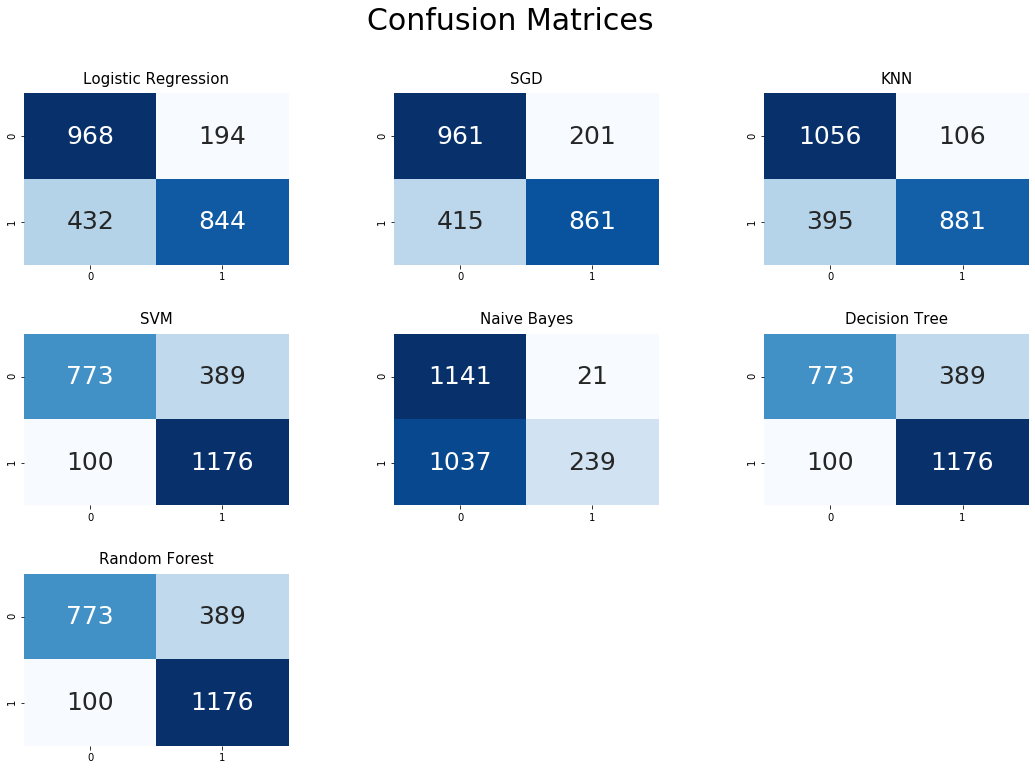

In [88]:
confusion_mat(y_test5, predictions5)

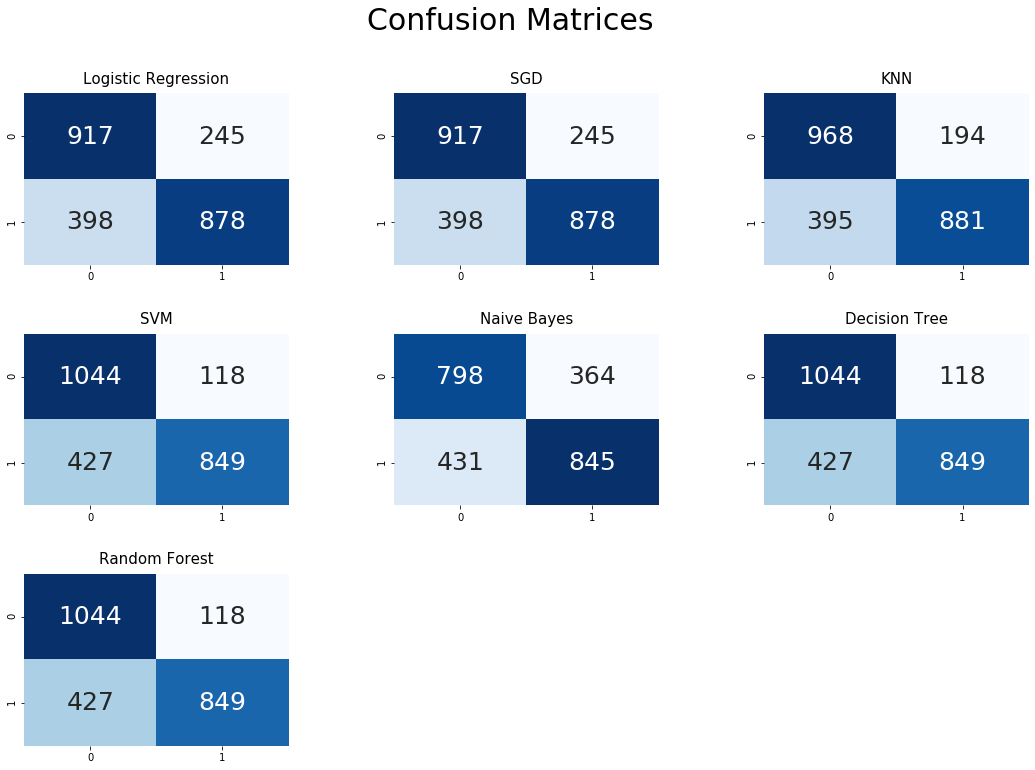

In [89]:
confusion_mat(y_test5_1, predictions5_1)

Putting a variance threshold like we did increased the FP of the Logistic Regression, SGD, KNN and Naive Bayes but decreased it in the SVM, Decision Tree and Random Forest. On the other hand, the FN of the last ones have been significantly increased. Like before, we can take the previous Naive Bayes as the safest model with only 21 FP. But if we want to choose the model with the least FP and yet with a decent amount of FN we should choose the previous KNN. Lets see how the confusion matrix on the train test looks like.

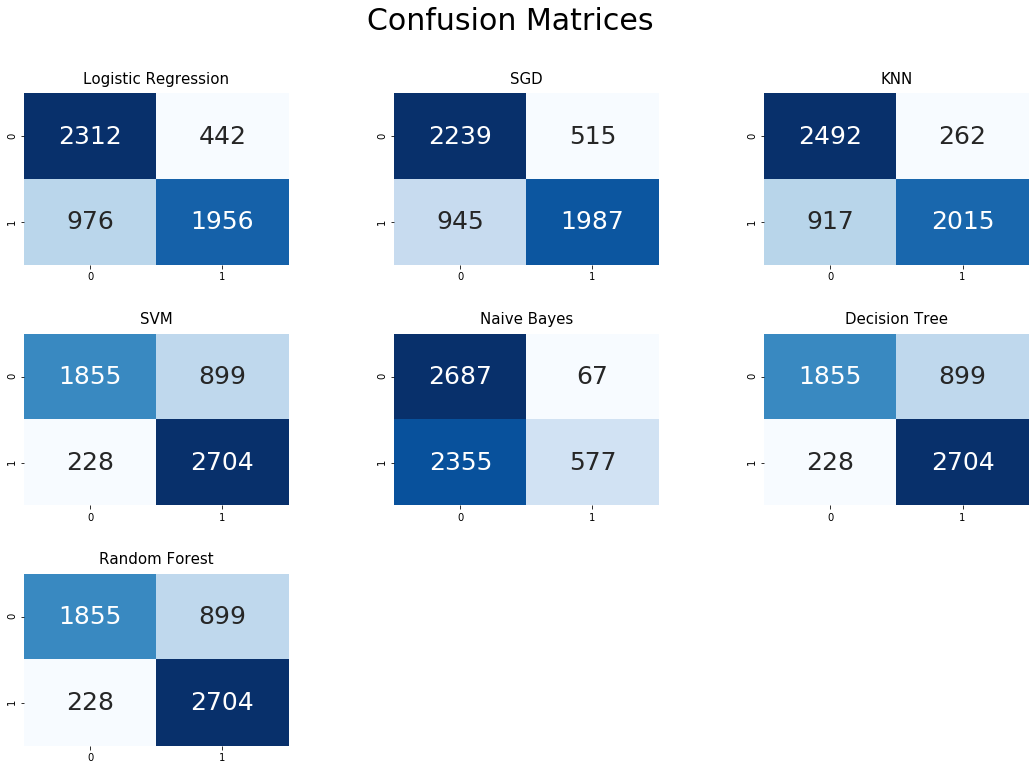

In [90]:
confusion_mat(y_train5, pred_dict(estimators5, X_train5))

We can see the KNN keeps its high precision on the train set with almost an opposite proportion of FP/FN compared to the rest of the good models. I also tested it with the variance threshold but it yielded worse results, so meanwhile the original KNN is the best model.

### Threshold optimization:

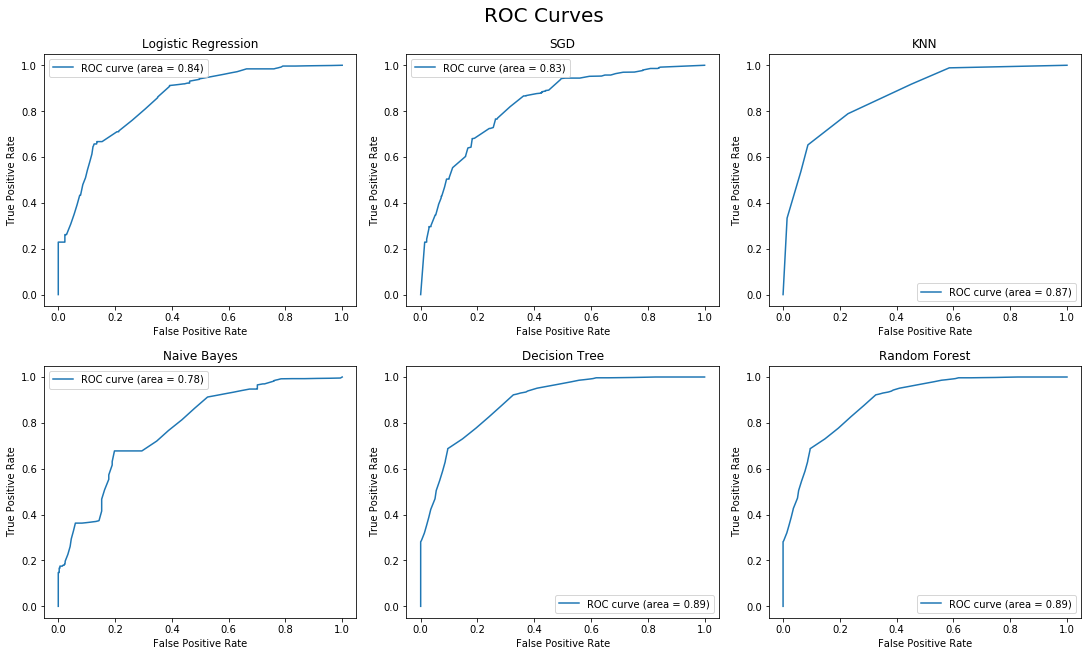

In [91]:
roc_curves(X_train5, y_train5, estimators5)

In [92]:
thresholds5 = best_thresholds_dict(X_train5, y_train5, estimators5)

In [93]:
predictions5 = pred_by_threshold_dict(estimators5, thresholds5, X_test5)

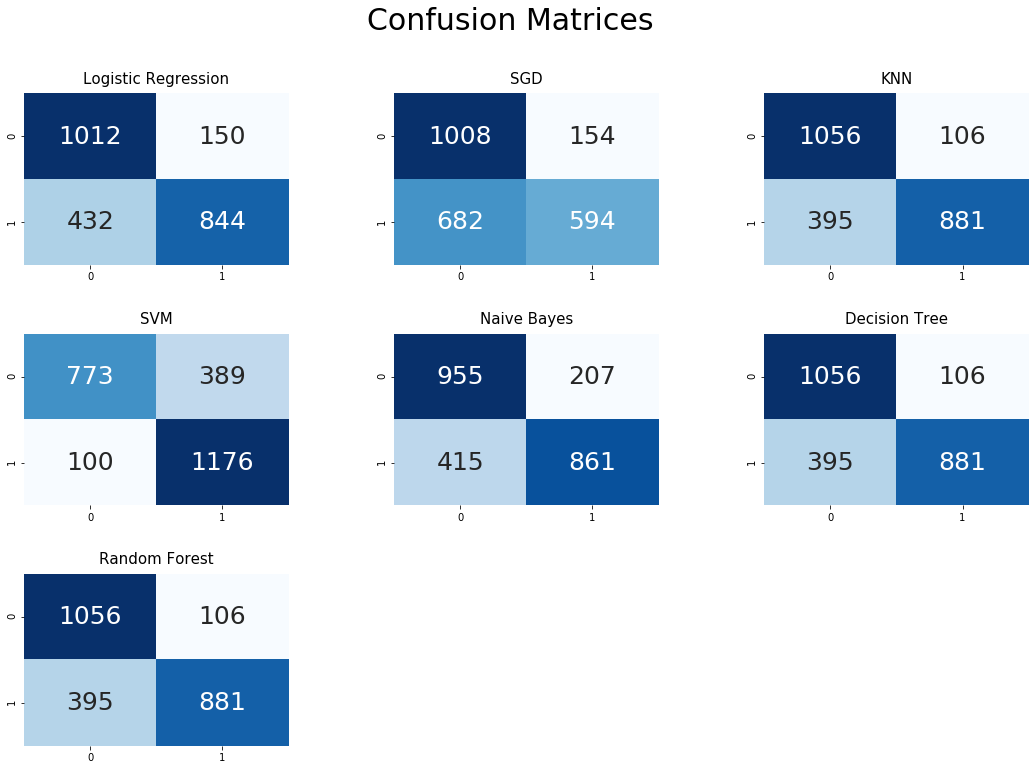

In [94]:
confusion_mat(y_test5, predictions5)

In [95]:
classification_rep(y_test5, predictions5)

====================================================Classification Reports===================================================
                  Logistic Regression                  
              precision    recall  f1-score   support

           0       0.70      0.87      0.78      1162
           1       0.85      0.66      0.74      1276

    accuracy                           0.76      2438
   macro avg       0.77      0.77      0.76      2438
weighted avg       0.78      0.76      0.76      2438

******************************************************
                          SGD                          
              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1162
           1       0.79      0.47      0.59      1276

    accuracy                           0.66      2438
   macro avg       0.70      0.67      0.65      2438
weighted avg       0.70      0.66      0.64      2438

*****************************************************

Optimizing the decision threshold didn't yield a better model than the KNN but made the Random Forest and Decision Tree match its score, and hence the KNN is the model we end up with.

In [96]:
area_clf = estimators5["KNN"]
area_threshold = thresholds5["KNN"]

In [97]:
area_model = MushroomModel(area_clf, area_threshold, original_df6, df6_encoder, removed_indices(original_df6, df6))

In [98]:
area_model.random_predict()

population: s
habitat: d


array([0])

In [99]:
sample2 = ['c', 'l']

In [100]:
lime_exp(X_train5, pd.DataFrame(area_model.sample_fit(sample2)), area_clf)

In [101]:
# lime_exp(X_train5, X_test5, area_clf)

Just for the sake of experimenting I also created XGBoost model. 

In [102]:
def xgboost_model(X, y, searchCV):
    
    params = {
        'min_child_weight': [0.1, 0.5, 1, 5],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 2],
        'max_depth': [2, 3, 4, 10]
        }
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)
    clf = searchCV(xgb, params, scoring=make_scorer(fbeta_score, beta=.5), n_jobs=-1, cv=5)
    clf.fit(X, y)
    print("XGBoost best score:", clf.best_score_)
    print("XGBoost best parameters:", clf.best_params_)
    return clf.best_estimator_

In [103]:
xgb = xgboost_model(X_train5, y_train5, RandomizedSearchCV)

[13:16:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost best score: 0.8368838427455196
XGBoost best parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.4}


In [104]:
confusion_matrix(y_test5, xgb.predict(X_test5))

array([[1056,  106],
       [ 395,  881]], dtype=int64)

We get the same confusion matrix as the KNN.

## Take 5: Unsupervised (clustering)

Now we are back to the original dataframe that we encoded with a OneHotEncoder (df2) but leaving the target feature out this time, and we shall see if dividing the data into 2 clusters using KMeans and Gaussian Mixture (separately) yields a good approximation to the original target.

In [105]:
# Plots the clustering Elbow method for a dataframe in the range of 1 to n
def kmeans_elbow(df, n):
    norm = []
    for k in range(1, n + 1):
        km = KMeans(n_clusters=k, n_jobs=-1)
        km.fit(df.drop("class", axis=1))
        norm.append(km.inertia_)
    plt.plot(range(1, n + 1), norm, 'bx-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Norm (Sum of squared distances)")
    plt.title("Elbow method for optimal k")

In [106]:
# kmeans_elbow(df2, 10)

In [107]:
# Calculates an f_0.5 score between the original labels feature and a given clustering labels vector
def clustering_score(labels, cl_labels):
    cm = confusion_matrix(labels, cl_labels)
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    return (1.25 * tp) / (1.25 * tp + 0.25 * fn + fp)

In [108]:
# Creates clustering models for the dataframe by using 2 clusters that would substitute the original binary target
# and outputs the clustering labels vectors and a table with the models scores
def clustering_model(df):
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(df.drop("class", axis=1))
    gmm = GaussianMixture(n_components=2, random_state=0).fit(df.drop("class", axis=1))
    kmeans_pred = kmeans.predict(df.drop("class", axis=1))
    gmm_pred = gmm.predict(df.drop("class", axis=1))
    kmeans_score = clustering_score(df["class"], kmeans_pred)
    gmm_score = clustering_score(df["class"], gmm_pred)
    estimators = {"KMeans": kmeans, "Gaussian Mixture": gmm}
    print(pd.DataFrame([["KMeans", kmeans_score],["Gaussian Mixture", gmm_score]], columns=["Model", "Score"]))
    return estimators

The models are initialized with a specific random_state to make sure the clustering labels correspond to the original labels (1 to 1 and 0 to 0), and also because it gives them the best score.

In [109]:
estimators6 = clustering_model(df2)

              Model     Score
0            KMeans  0.863381
1  Gaussian Mixture  0.862641


In [110]:
predictions6 = pred_dict(estimators6, df2.drop("class", axis=1))

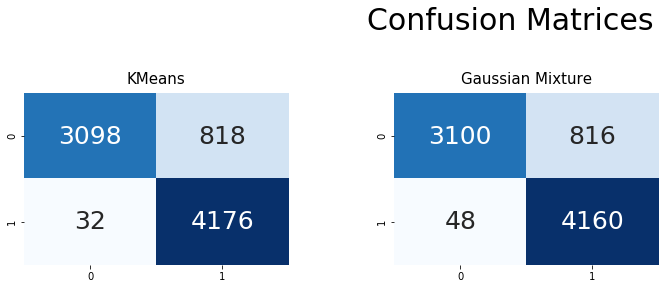

In [111]:
confusion_mat(df2["class"], predictions6)

In [112]:
classification_rep(df2["class"], predictions6)

====================================================Classification Reports===================================================
                         KMeans                        
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3916
           1       0.84      0.99      0.91      4208

    accuracy                           0.90      8124
   macro avg       0.91      0.89      0.89      8124
weighted avg       0.91      0.90      0.89      8124

******************************************************
                    Gaussian Mixture                   
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      3916
           1       0.84      0.99      0.91      4208

    accuracy                           0.89      8124
   macro avg       0.91      0.89      0.89      8124
weighted avg       0.91      0.89      0.89      8124

*****************************************************

The models separate the data almost the same, and unfortunately they both have a high FP rate. The score of the KMeans is a little better so that's the model we end up with.

In [113]:
clusters_model = MushroomModel(estimators6["KMeans"], 0.5, df, df2_encoder, removed_indices(df, df2))

In [114]:
clusters_model.random_predict()

cap-shape: k
cap-surface: s
cap-color: r
bruises: t
odor: n
gill-attachment: f
gill-spacing: w
gill-size: n
gill-color: k
stalk-shape: e
stalk-root: e
stalk-surface-above-ring: y
stalk-surface-below-ring: s
stalk-color-above-ring: p
stalk-color-below-ring: p
veil-color: w
ring-number: t
ring-type: l
spore-print-color: b
population: y
habitat: g


array([1])

### Ending remark

One could mess with the beta value of the f_beta function a little more to try to get better precision results.